# Inference

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
# Load the dataset
df = pd.read_excel('Data_HackLab.xlsx', sheet_name='Worksheet')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
# Check data types
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [4]:
# Convert MonthlyCharges and TotalCharges to numeric, coercing errors to NaN
df['MonthlyCharges'] = pd.to_numeric(df['MonthlyCharges'], errors='coerce')
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Optionally drop rows with NaN values if conversion failed for any row
df = df.dropna(subset=['MonthlyCharges', 'TotalCharges'])


In [5]:
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

In [6]:
# Check for missing values in customer data
print("Missing values in customer data:")
df.isnull().sum()

Missing values in customer data:


customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [7]:
# Drop customerID column as it's not needed for clustering
df.drop("customerID", axis=1, inplace=True)

In [8]:
df.head(1)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No


In [9]:
# Encode categorical variables. For binary columns (Yes/No), you can map them to 1/0
binary_cols = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']

for col in binary_cols:
    df[col] = df[col].map({"Yes": 1, "No": 0})

# For gender, map Male/Female to numeric (or consider one-hot encoding)
df['gender'] = df['gender'].map({"Male": 1, "Female": 0})

# For columns with more than two categories, use one-hot encoding: 
# e.g. InternetService, Contract, PaymentMethod
df = pd.get_dummies(df, columns=['MultipleLines','InternetService','OnlineSecurity', 
               'OnlineBackup', 'DeviceProtection', 'TechSupport', 
               'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod'], drop_first=True)

# 3. Feature Scaling

# Identify numeric columns that need to be scaled.
# You might want to scale columns like tenure, MonthlyCharges, TotalCharges.
numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# 4. Optional: Separate churn variable for later analysis
churn = df['Churn']
df_features = df.drop('Churn', axis=1)

In [10]:
# Check for missing values AFTER data pre processing
print("Missing values in customer data:")
df.isnull().sum()

Missing values in customer data:


gender                                   0
SeniorCitizen                            0
Partner                                  0
Dependents                               0
tenure                                   0
PhoneService                             0
PaperlessBilling                         0
MonthlyCharges                           0
TotalCharges                             0
Churn                                    0
MultipleLines_No phone service           0
MultipleLines_Yes                        0
InternetService_Fiber optic              0
InternetService_No                       0
OnlineSecurity_No internet service       0
OnlineSecurity_Yes                       0
OnlineBackup_No internet service         0
OnlineBackup_Yes                         0
DeviceProtection_No internet service     0
DeviceProtection_Yes                     0
TechSupport_No internet service          0
TechSupport_Yes                          0
StreamingTV_No internet service          0
StreamingTV

In [22]:
# After performing your conversions
df = df.dropna()  # Drops all rows with any NaN values

# Check to see if there are any NaNs left
if df.isnull().sum().sum() == 0:
    print("No missing values!")

No missing values!


In [11]:
df.head(1)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,...,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,-1.280248,0,1,-1.161694,-0.994194,No,...,False,False,False,False,False,False,False,False,True,False


In [12]:
print(df_features.dtypes)

gender                                     int64
SeniorCitizen                              int64
Partner                                    int64
Dependents                                 int64
tenure                                   float64
PhoneService                               int64
PaperlessBilling                           int64
MonthlyCharges                           float64
TotalCharges                             float64
MultipleLines_No phone service              bool
MultipleLines_Yes                           bool
InternetService_Fiber optic                 bool
InternetService_No                          bool
OnlineSecurity_No internet service          bool
OnlineSecurity_Yes                          bool
OnlineBackup_No internet service            bool
OnlineBackup_Yes                            bool
DeviceProtection_No internet service        bool
DeviceProtection_Yes                        bool
TechSupport_No internet service             bool
TechSupport_Yes     

Number of clusters: 2, WCSS: 41935.57, Silhouette Score: 0.235
Number of clusters: 3, WCSS: 30747.78, Silhouette Score: 0.284
Number of clusters: 4, WCSS: 28175.27, Silhouette Score: 0.228
Number of clusters: 5, WCSS: 26438.96, Silhouette Score: 0.206
Number of clusters: 6, WCSS: 25324.68, Silhouette Score: 0.186
Number of clusters: 7, WCSS: 24604.87, Silhouette Score: 0.182
Number of clusters: 8, WCSS: 23120.25, Silhouette Score: 0.146
Number of clusters: 9, WCSS: 22627.95, Silhouette Score: 0.146
Number of clusters: 10, WCSS: 22040.87, Silhouette Score: 0.146


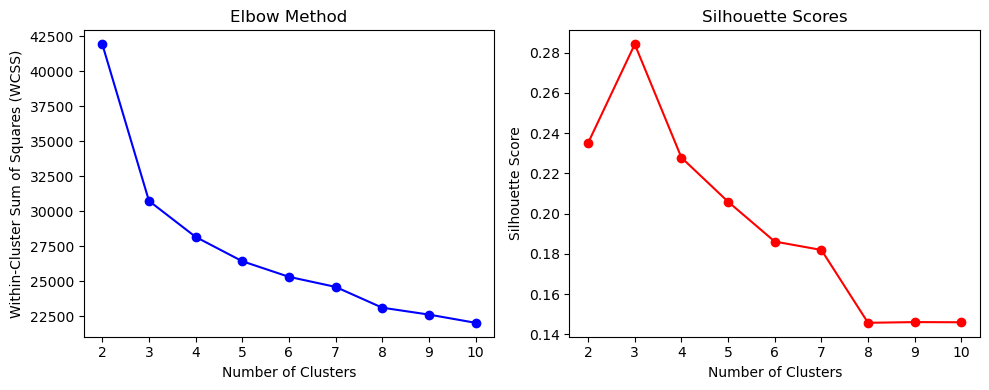

In [13]:
# 5. Clustering: K-Means
# Determine an appropriate number of clusters using the elbow method and silhouette score

wcss = []  # within-cluster sum of squares
silhouette_scores = []

K = range(2, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(df_features)
    wcss.append(kmeans.inertia_)
    score = silhouette_score(df_features, cluster_labels)
    silhouette_scores.append(score)
    print(f"Number of clusters: {k}, WCSS: {kmeans.inertia_:.2f}, Silhouette Score: {score:.3f}")

# Plot the elbow method
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(K, wcss, 'bo-', markersize=6)
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method')

# Plot silhouette scores
plt.subplot(1,2,2)
plt.plot(K, silhouette_scores, 'ro-', markersize=6)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores')
plt.tight_layout()
plt.show()

# Choose the optimal number of clusters based on the above metrics.
# For this example, let's assume 3 clusters is optimal.
optimal_clusters = 3
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
df_features['Cluster'] = kmeans.fit_predict(df_features)


Cluster Sizes:
Cluster
2    3251
0    2261
1    1520
Name: count, dtype: int64
Cluster Profiles (Means):
           gender  SeniorCitizen   Partner  Dependents    tenure  \
Cluster                                                            
0        0.501548       0.205219  0.689076    0.346307  1.040194   
1        0.509211       0.034211  0.482237    0.419079 -0.071466   
2        0.504768       0.192556  0.338973    0.208859 -0.690018   

         PhoneService  PaperlessBilling  MonthlyCharges  TotalCharges  
Cluster                                                                
0            0.928793          0.691287        0.823174      1.274991  
1            1.000000          0.292763       -1.453336     -0.713877  
2            0.840357          0.664411        0.107005     -0.552956  


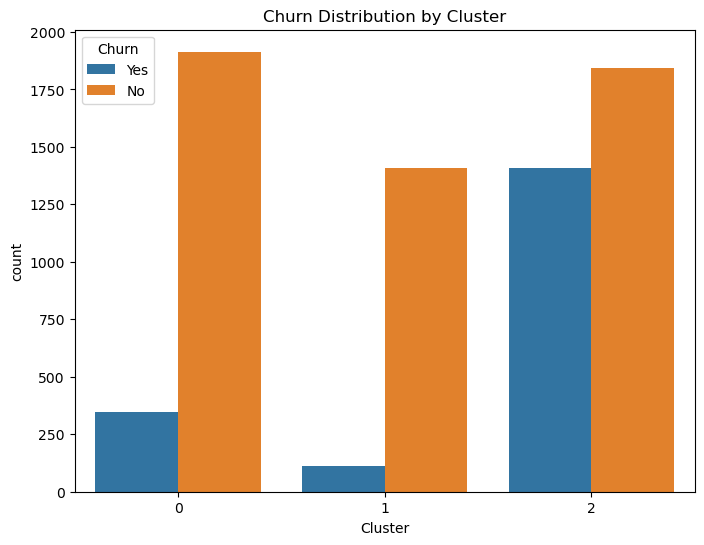

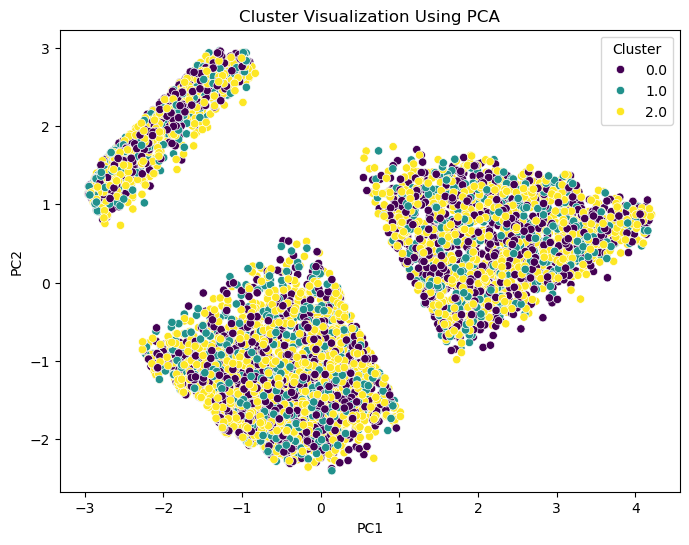

In [14]:
# 6. Analyzing the clusters

# Add churn back into the dataframe for analysis
df_features['Churn'] = churn.values

# Display cluster sizes
print("\nCluster Sizes:")
print(df_features['Cluster'].value_counts())

# Select only columns of numeric types (this now includes your properly converted booleans)
numeric_df = df_features.select_dtypes(include=['number'])

# Now, aggregate by cluster
cluster_profile = numeric_df.groupby('Cluster').mean()
print("Cluster Profiles (Means):")
print(cluster_profile)


# Visualize the distribution of churn in each cluster
plt.figure(figsize=(8, 6))
sns.countplot(data=df_features, x='Cluster', hue='Churn')
plt.title("Churn Distribution by Cluster")
plt.show()

# Optionally, use PCA to reduce dimensions and plot the clusters
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
components = pca.fit_transform(df_features.drop('Churn', axis=1))
df_components = pd.DataFrame(data=components, columns=['PC1', 'PC2'])
df_components['Cluster'] = df_features['Cluster']

plt.figure(figsize=(8,6))
sns.scatterplot(data=df_components, x='PC1', y='PC2', hue='Cluster', palette='viridis')
plt.title("Cluster Visualization Using PCA")
plt.show()
